## Part 3: Regression for Joint Angles

In [220]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

PROJECT_ROOT = Path(os.path.abspath(__file__)).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
EMG_DIR = DATA_DIR / "EMG"
OUTPUT_DIR = PROJECT_ROOT / "output" 
EMG_OUTPUT_DIR = OUTPUT_DIR / "emg"
s1_dir = EMG_DIR / "s1"

mat_path = s1_dir / "S1_E1_A1.mat"   # adapt name if needed
data = loadmat(mat_path, squeeze_me=True)

print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


### Visualize Data

EMG data dimension: (2292525, 16)
EMG data type: <class 'numpy.ndarray'>
Glove data dimension: (2292525, 5)
Glove data type: <class 'numpy.ndarray'>


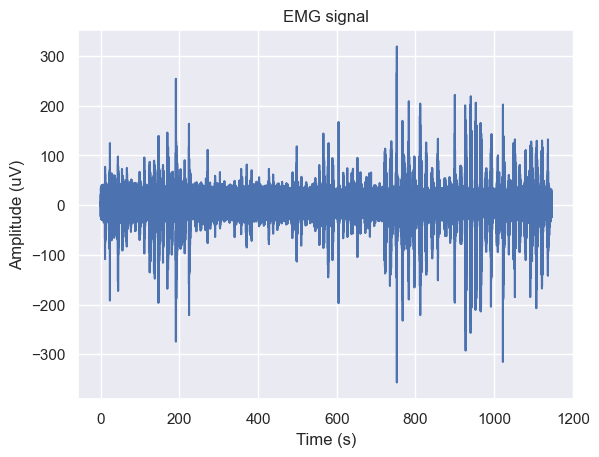

[33.7683   87.193    43.706367 70.8381   17.617765]


In [281]:
emg_data = np.asarray(data["emg"])
glove     = np.asarray(data["glove"])
data_index_where_movement_ends = -1
emg_data = emg_data[:data_index_where_movement_ends, :]*1e6 #convert data from V to uV

# use glove joints 3, 6, 8, 11, 14
joint_idx = [3, 6, 8, 11, 14] 
glove_data_index = glove[:data_index_where_movement_ends, joint_idx]
print("EMG data dimension:", emg_data.shape)
print("EMG data type:", type(emg_data))
print("Glove data dimension:", glove_data_index.shape)
print("Glove data type:", type(glove_data_index))

#Plot first channel to get a sense of the data
fs = 2000  # Hz
t = np.arange(emg_data.shape[0]) / fs  #time in seconds
plt.close("all")
fig, ax = plt.subplots()
ax.plot(t,emg_data[:, 9])   
ax.set_title("EMG signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (uV)")
fig.savefig(os.path.join(EMG_OUTPUT_DIR, "raw_EMG_signal.png"),dpi=300, bbox_inches="tight")
plt.show()

# over the whole dataset (or just test set – be consistent)
joint_ranges = glove_data_index.max(axis=0) - glove_data_index.min(axis=0)
print(joint_ranges)   # 5 values: thumb, index, middle, ring, pinky


### Check PSD -> already bandpass and notch filtered

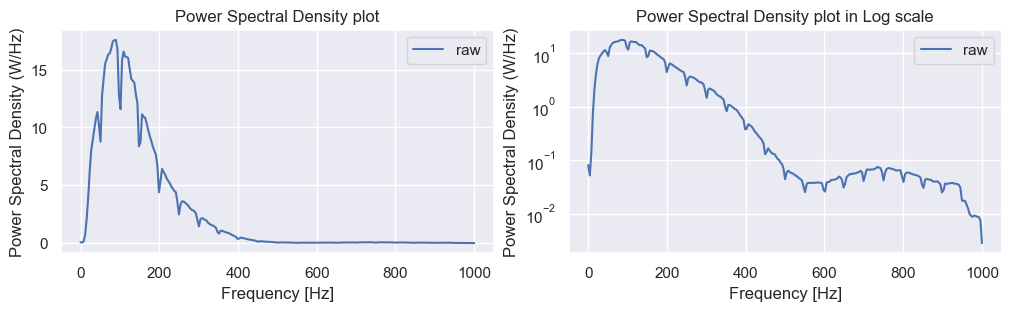

In [225]:
# Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data[:, 8], fs=2000, nperseg=512)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")
fig.savefig(os.path.join(EMG_OUTPUT_DIR, "PSD.png"),dpi=300, bbox_inches="tight")

### Rectify EMG data and calculate moving average envelopes

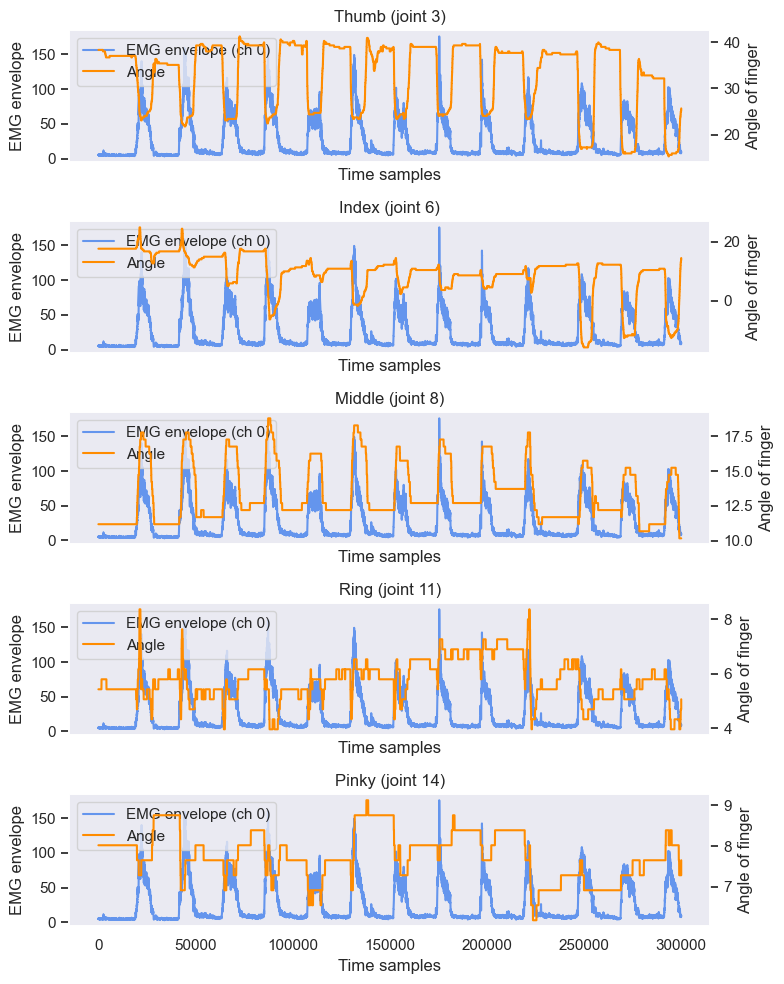

In [263]:
emg_rectified = np.abs(emg_data)  
mov_mean_size = 200 #100 ms smoothing, can try different values
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size

EMG_envelopes = convolve1d(
    emg_rectified,
    weights=mov_mean_weights,
    axis=0,      
) #moving average envelopes

#Separate plot for each joint
joint_names = ["Thumb (joint 3)", "Index (joint 6)", "Middle (joint 8)", "Ring (joint 11)", "Pinky (joint 14)"]
n_joints = glove_data_index.shape[1]
view_window = 300000  # or something shorter
fig, axes = plt.subplots(n_joints, 1, figsize=(8, 10), sharex=True)
if n_joints == 1:
    axes = [axes]

for j in range(n_joints):
    ax = axes[j]
    ax.plot(EMG_envelopes[:view_window, 0], color="cornflowerblue", label="EMG envelope (ch 0)")
    ax.set_ylabel("EMG envelope")
    ax.set_xlabel("Time samples")
    ax.grid(False)
    ax2 = ax.twinx()
    ax2.plot(glove_data_index[:view_window, j], color="darkorange", label="Angle")
    ax2.set_ylabel("Angle of finger")
    ax2.grid(False)
    ax.set_title(joint_names[j])
    # combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="upper left")
fig.savefig(os.path.join(EMG_OUTPUT_DIR, "EMG_envelope_joint_angle.png"),dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

### Perform sliding windows

In [237]:
fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 100e-3  # [s]
incremental_window_length_sec = 20e-3  # [s]
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

### Split time series into training, validation, and test data

In [254]:
from sklearn.model_selection import train_test_split
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows, Labels_windows = extract_time_windows_regression(EMG_envelopes, glove_data_index, fs, emg_window_length_sec, incremental_window_length_sec)

# randomly pick data for train, validation and test
#EMG_train_windows, EMG_test_windows, Labels_train_windows, Labels_test_windows = train_test_split(EMG_windows, Labels_windows, test_size=0.2, random_state=151)

EMG_windows, Labels_windows = extract_time_windows_regression(EMG_envelopes, glove_data_index, fs,emg_window_length_sec, incremental_window_length_sec)
n_windows = EMG_windows.shape[0]

#70% train, 15% validation, 15% test
n_train = int(0.7 * n_windows)
n_val = int(0.15 * n_windows)

EMG_train_windows = EMG_windows[:n_train]
Labels_train_windows = Labels_windows[:n_train]

EMG_val_windows = EMG_windows[n_train:n_train + n_val]
Labels_val_windows = Labels_windows[n_train:n_train + n_val]

EMG_test_windows = EMG_windows[n_train + n_val:]
Labels_test_windows  = Labels_windows[n_train + n_val:]

print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG validation data shape: {EMG_val_windows.shape}, Validation label shape: {Labels_val_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

EMG train data shape: (40116, 200, 16), Train label shape: (40116, 200, 5)
EMG validation data shape: (8596, 200, 16), Validation label shape: (8596, 200, 5)
EMG test data shape: (8597, 200, 16), Test label shape: (8597, 200, 5)


### Perform feature extraction

In [255]:
def extract_more_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    Extracts features based on the provided formula table.
    Input shape: (n_windows, win_len, n_channels)
    """
    EMG_tkeo = []
    m0 = []
    m2 = []
    m4 = []
    sparsity = []
    irf = []
    wlr = []
    
    eps = 1e-8 # Small epsilon to prevent division by zero or log of zero

    for w in range(EMG_windows.shape[0]):
        EMG_tkeo_w = []
        m0_w = []
        m2_w = []
        m4_w = []
        sparsity_w = []
        irf_w = []
        wlr_w = []
        
        for c in range(EMG_windows.shape[2]):
            # Extract signal for current window and channel
            x = EMG_windows[w, :, c]
            
            # --- 1. Teager-Kaiser Energy Operator (Formula f8) ---
            # Formula: log( sum( x[j]^2 - x[j-1]*x[j+1] ) )
            # Operates on the time axis 'j'
            tkeo_op = x[1:-1]**2 - x[:-2] * x[2:]
            tkeo_sum = np.sum(tkeo_op)
            # Use abs to handle potential noise-induced negatives before log
            EMG_tkeo_w.append(np.log(np.abs(tkeo_sum) + eps))

            # --- 2. Calculate Derivatives ---
            dx = np.diff(x)       # 1st Derivative
            ddx = np.diff(dx)     # 2nd Derivative
            
            # --- 3. Root Squared Moments (Formula m0, m2, m4) ---
            # Formula: sqrt( 1/N * sum( x^2 ) )
            m0_val = np.sqrt(np.mean(x ** 2))
            m2_val = np.sqrt(np.mean(dx ** 2))
            m4_val = np.sqrt(np.mean(ddx ** 2))
            
            m0_w.append(m0_val)
            m2_w.append(m2_val)
            m4_w.append(m4_val)
            
            # --- 4. Derived Features ---
            
            # Sparseness (Formula f4)
            # Formula: log( m0 / ( sqrt(m0-m2) * sqrt(m0-m4) ) )
            # Note: Using abs inside sqrt to ensure stability if unnormalized
            denom_sparsity = np.sqrt(np.abs(m0_val - m2_val)) * np.sqrt(np.abs(m0_val - m4_val))
            S = m0_val / (denom_sparsity + eps)
            sparsity_w.append(np.log(S + eps))
            
            # Irregularity Factor (Formula f5)
            # Formula: log( sqrt( m2 / (m0 * m4) ) )
            if_val = np.sqrt(m2_val / (m0_val * m4_val + eps))
            irf_w.append(np.log(if_val + eps))
            
            # Waveform Length Ratio (Formula f6)
            # Formula: log( sum(|ddx|) / sum(|dx|) )
            # Note: The formula in the image puts the 2nd derivative (ddx) on top
            wl_dx = np.sum(np.abs(dx))
            wl_ddx = np.sum(np.abs(ddx))
            wl_ratio = wl_ddx / (wl_dx + eps)
            wlr_w.append(np.log(wl_ratio + eps))
            
        # Append window results to main lists
        EMG_tkeo.append(EMG_tkeo_w)
        m0.append(m0_w)
        m2.append(m2_w)
        m4.append(m4_w)
        sparsity.append(sparsity_w)
        irf.append(irf_w)
        wlr.append(wlr_w)

    return EMG_tkeo, m0, m2, m4, sparsity, irf, wlr

In [256]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    
    Labels_mean = np.mean(Labels_windows,axis=1)
    EMG_tkeo, sparsity, irf, wlr = extract_more_features(EMG_windows, Labels_windows)
    EMG_tkeo = np.array(EMG_tkeo)   # (n_windows, n_channels)
    sparsity = np.array(sparsity)
    irf = np.array(irf)
    wlr = np.array(wlr)
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude, EMG_tkeo, sparsity, irf, wlr), axis=1)
    return EMG_extracted_features, Labels_mean

In [ ]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_val_extracted_features, Labels_val_mean = extract_features(EMG_val_windows, Labels_val_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG validation extracted features shape: {}, Finger labels feature shape:{}".format(EMG_val_extracted_features.shape, Labels_val_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

### Visualize feature correlation matrix

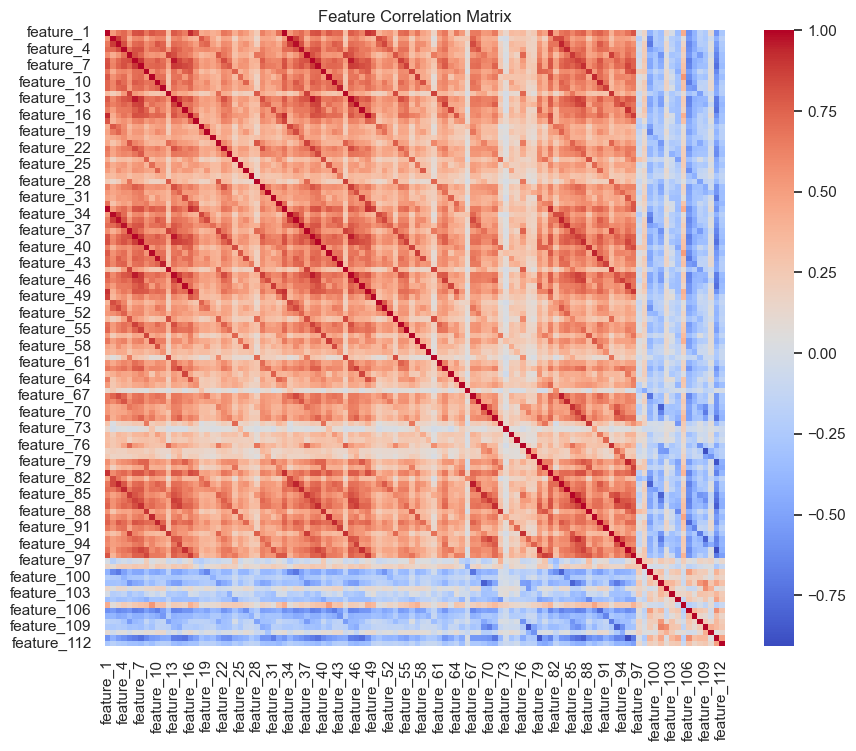

In [258]:
#Normalizaztion and correlation between features 
# Create a DataFrame from the extracted features
df_features = pd.DataFrame(EMG_train_extracted_features, columns=[f'feature_{i+1}' for i in range(EMG_train_extracted_features.shape[1])])
# Compute the correlation matrix
correlation_matrix = df_features.corr()
#plot a matrix heatmap using the correlation matrix
fig = plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
fig.savefig(os.path.join(EMG_OUTPUT_DIR, "feature_correlation_matrix"),dpi=300, bbox_inches="tight")
plt.show()

### Perform regression with linear SVR

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error

# 1) Scale features once
scaler = StandardScaler()
X_train = scaler.fit_transform(EMG_train_extracted_features)
X_val   = scaler.transform(EMG_val_extracted_features)
X_test  = scaler.transform(EMG_test_extracted_features)

n_joints = Labels_train_mean.shape[1] 
pred_list = np.zeros_like(Labels_test_mean)
mses = []

# 2) One SVR per joint
for j in range(n_joints):
    svr = LinearSVR(C=10.0, epsilon=0.0, random_state=0, max_iter=10000) #try tuning parameters to see if fit is a bit better (esp for middle finger)
    svr.fit(X_train, Labels_train_mean[:, j]) #train on joint j
    pred_list[:, j] = svr.predict(X_test) #store predictions
    mses.append(mean_squared_error(Labels_test_mean[:, j], pred_list[:, j]))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


MSE per joint: [45.37448226315383, 229.28011707345317, 5.344929391934658, 46.26014121599809, 16.253195486533464]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Visualize results to inspect performance of regressor 

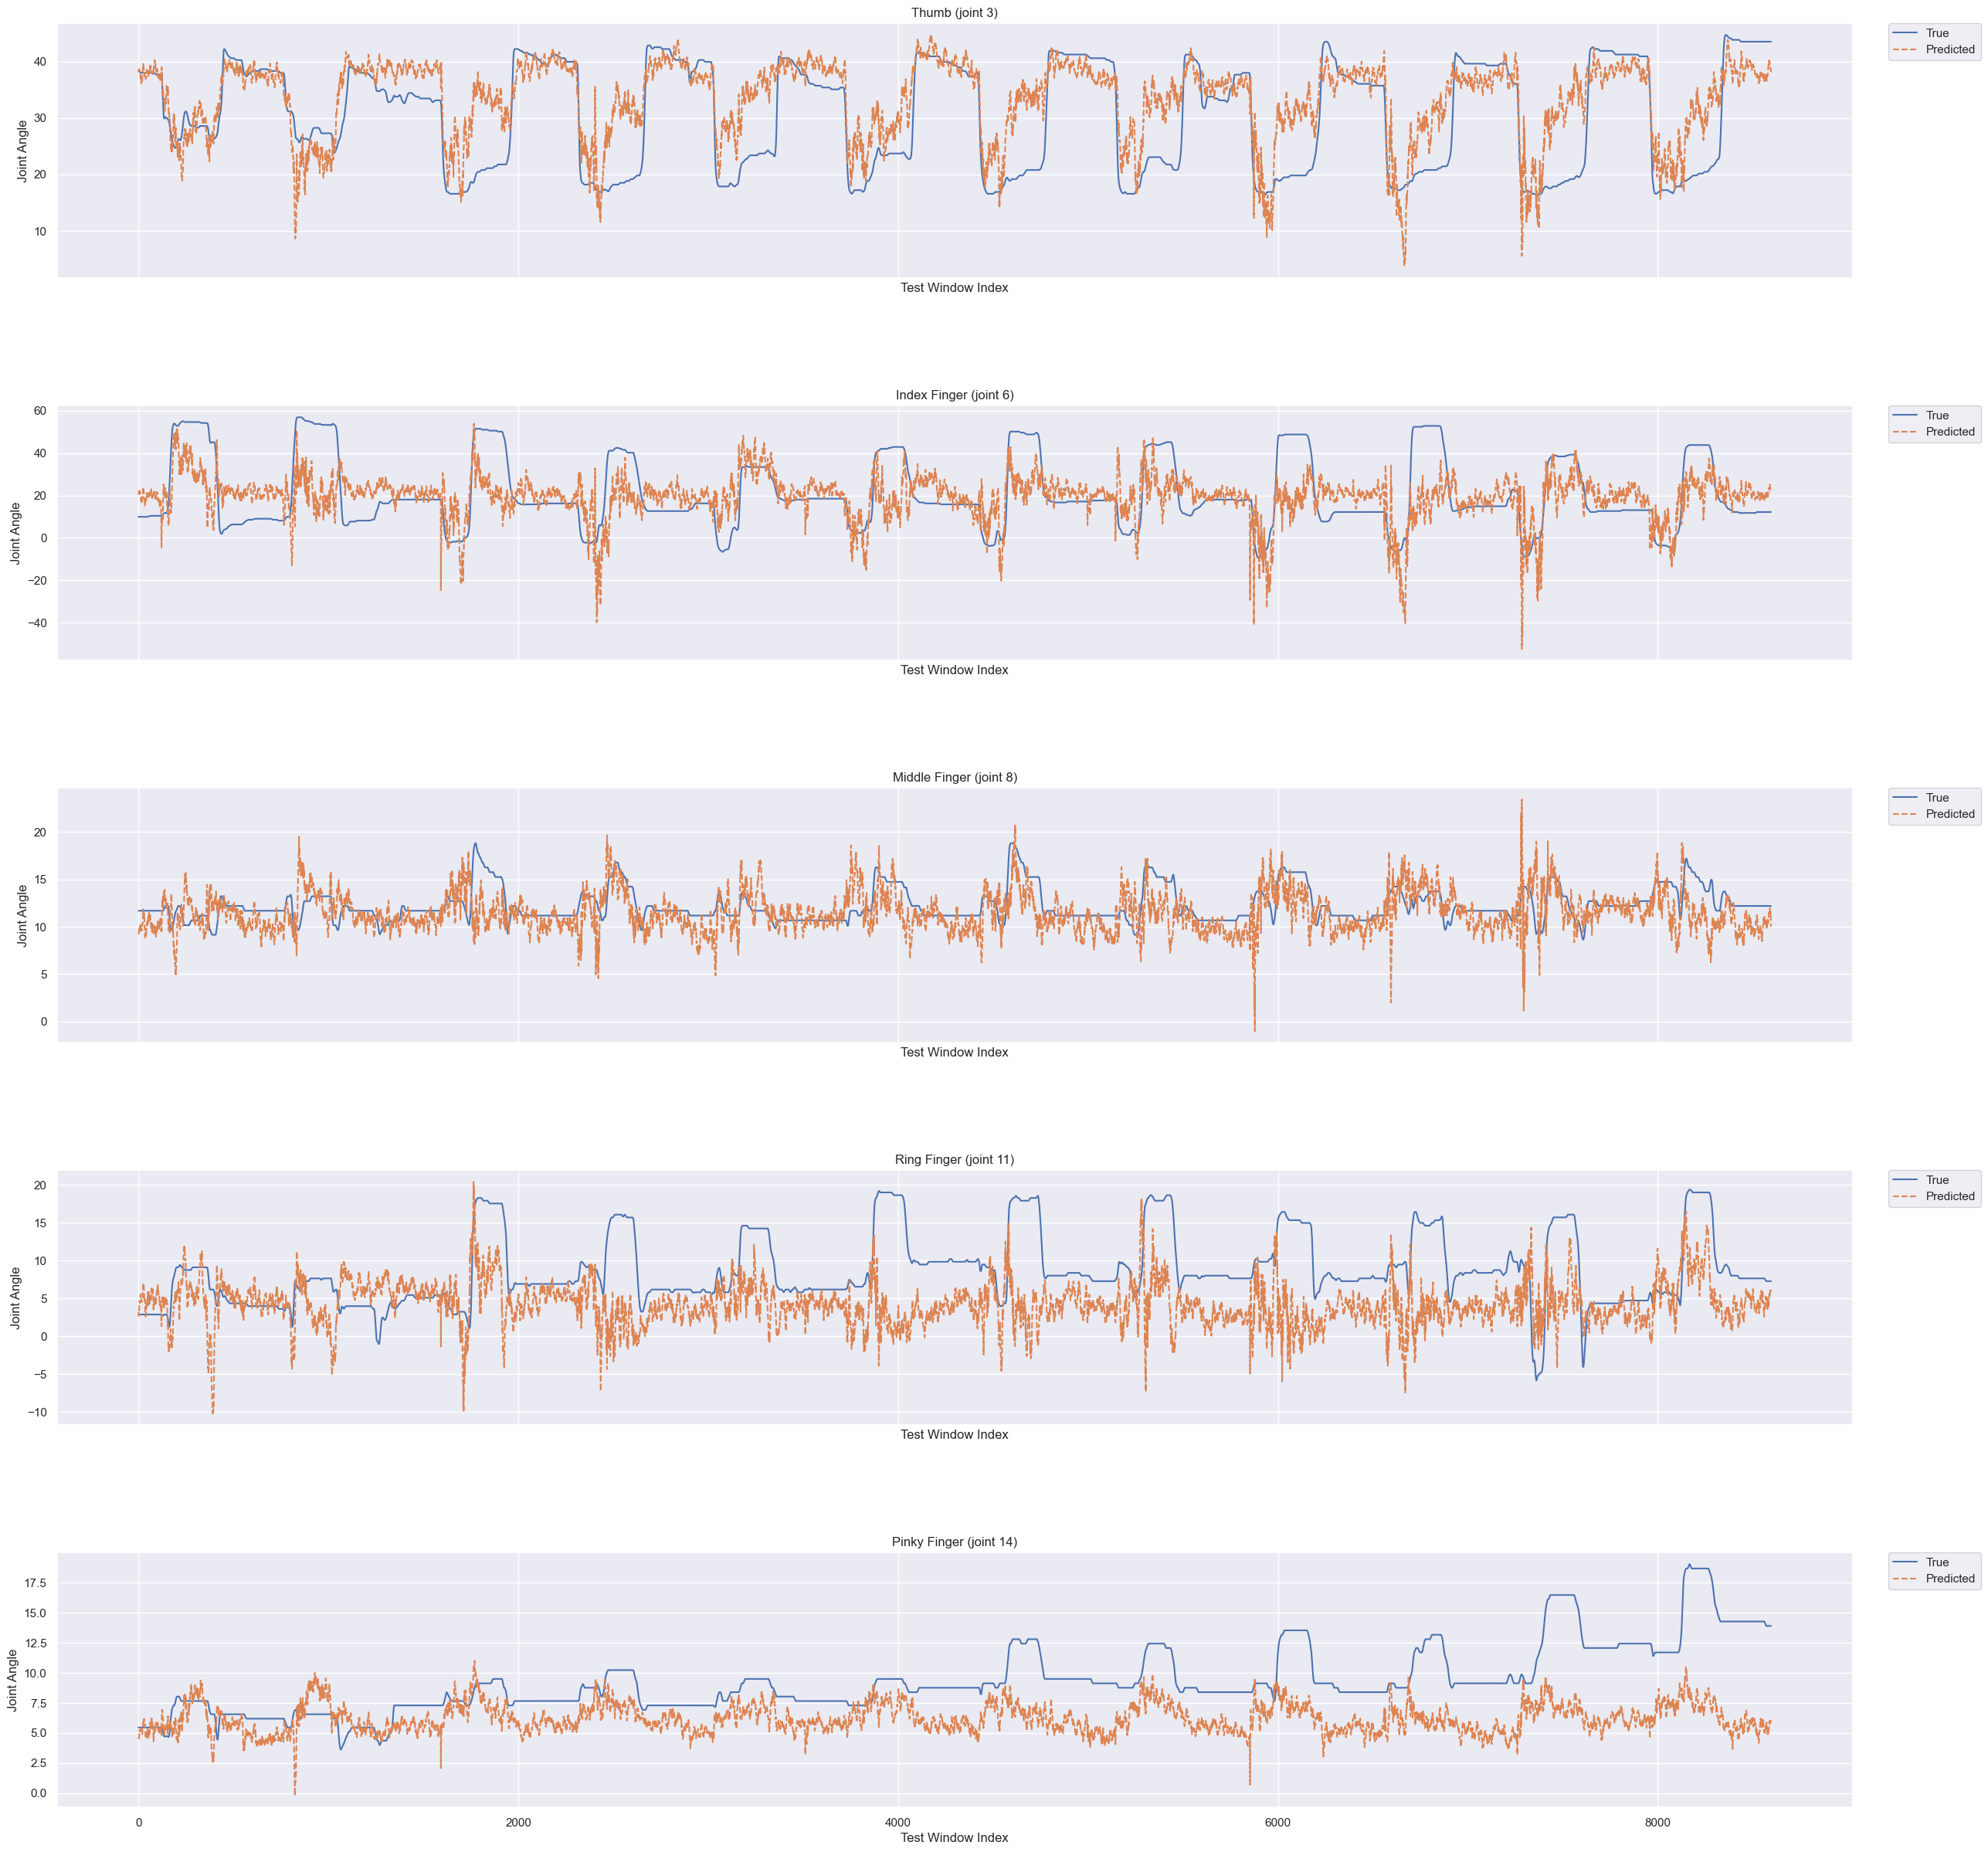

In [276]:
#plot results of linear SVR
joint_names = ["Thumb (joint 3)","Index Finger (joint 6)","Middle Finger (joint 8)","Ring Finger (joint 11)", "Pinky Finger (joint 14)"]
n_to_show = 50000  # number of test windows to display
fig, axes = plt.subplots(n_joints, 1, figsize=(30, 30), sharex=True)
fig.subplots_adjust(hspace=0.5) 

for j in range(n_joints):
    ax = axes[j]
    ax.plot(Labels_test_mean[:n_to_show, j], label="True")
    ax.plot(pred_list[:n_to_show, j], "--", label="Predicted")
    ax.set_ylabel("Joint Angle")
    ax.set_xlabel("Test Window Index")
    ax.set_title(joint_names[j])
    ax.legend(loc="upper left",bbox_to_anchor=(1.02, 1.0),borderaxespad=0.)
plt.show()


### Evaluate performance with MSE, RMSE, MAE, R2

In [282]:
#3) Evaluate performance: MSE, RMSE, MAE, R^2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse_list, rmse_list, mae_list, r2_list = [], [], [], []
for j in range(n_joints):
    y_true = Labels_test_mean[:, j]
    y_pred = pred_list[:, j]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

print("MSE per joint :", mse_list)
print("RMSE per joint:", rmse_list)
print("MAE per joint :", mae_list)
print("R² per joint  :", r2_list)


# already have per-joint RMSE
rmse = np.sqrt([
    mean_squared_error(Labels_test_mean[:, j], pred_list[:, j])
    for j in range(n_joints)
])

# NRMSE using std of true test angles
joint_std = Labels_test_mean.std(axis=0)
nrmse_std = rmse / joint_std   # optionally * 100 for %

print("RMSE per joint:", rmse)
print("NRMSE_std per joint:", nrmse_std)


MSE per joint : [45.37448226315383, 229.28011707345317, 5.344929391934658, 46.26014121599809, 16.253195486533464]
RMSE per joint: [6.73605836251096, 15.141998450450759, 2.3119103338872504, 6.801480810529284, 4.031525205990094]
MAE per joint : [5.182237243634102, 11.638677813120408, 1.7341160717958468, 5.209583338704907, 3.226932303694476]
R² per joint  : [0.500147017621845, 0.16775745350802196, -0.8067009098227529, -1.214750842247768, -1.1367516024661404]
RMSE per joint: [ 6.73605836 15.14199845  2.31191033  6.80148081  4.03152521]
NRMSE_std per joint: [0.70700282 0.91227328 1.34413575 1.4882039  1.46176318]


### Try a nonlinear SVR model to compare to linear

In [ ]:
from sklearn.svm import SVR

pred_rbf = np.zeros_like(Labels_test_mean)
mses_rbf = []

for j in range(n_joints):
    svr_rbf = SVR(kernel="rbf", C=10.0, epsilon=0.01, gamma="scale")
    svr_rbf.fit(X_train, Labels_train_mean[:, j])
    pred_rbf[:, j] = svr_rbf.predict(X_test) 
    mses_rbf.append(mean_squared_error(Labels_test_mean[:, j],pred_rbf[:, j]))

print("RBF SVR MSE per joint:", mses_rbf)

RBF SVR MSE per joint: [43.22684134025228, 282.41773002659886, 7.600900922217555, 49.405390030085925, 17.024669512828734]


### Visualize results of nonlinear SVR regression

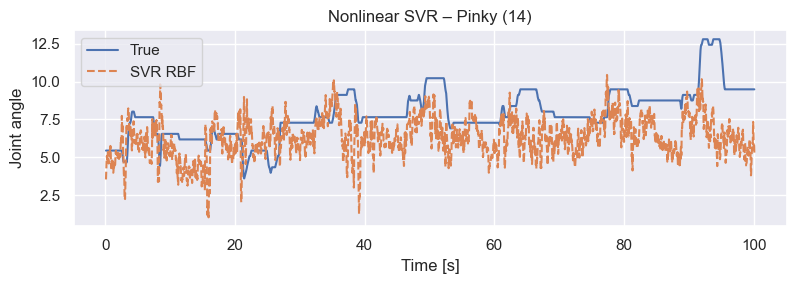

In [163]:
#plot results of nonlinear SVR
joint_names = ["Thumb (3)", "Index (6)", "Middle (8)", "Ring (11)", "Pinky (14)"]

j = 4  
n_to_show = 5000
step_sec = incremental_window_length_sec
win_sec  = emg_window_length_sec
t = np.arange(n_to_show) * step_sec + win_sec/2

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(t, Labels_test_mean[:n_to_show, j], label="True")
ax.plot(t, pred_rbf[:n_to_show, j], "--", label="SVR RBF")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Joint angle")
ax.set_title(f"Nonlinear SVR – {joint_names[j]}")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()
